<a href="https://colab.research.google.com/github/sigmunjr/TEK5030_deep_learning_torch/blob/main/TEK5030_deep_learning_torch_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INF5030 - Deep learning Lab

The goal of this exercise is to give you some hands on experiance with building and training *deep neural networks*.

To simplify setup, this execise will be run in Jupyter notebook/colab. Still some fun exercises are hard to do in a web browser. I recommende those with a proper hardware setup to also try [EX3_live_training.py](https://gitlab.com/sigmund.rolfsjord/unik4690_deep_learning_lab/-/blob/master/EX3_live_training.py) from an older lab [TEK5030 Deep learning lab (2020)](https://gitlab.com/sigmund.rolfsjord/unik4690_deep_learning_lab). In this lab you can also find code for running detection networks live.

For those interested in learning [Tensorflow](tensorflow.org), you can try exercises from [https://github.com/sigmunjr/TEK5030_deep_learning](https://github.com/sigmunjr/TEK5030_deep_learning).

The exercise will be focused around the *deep learning framework* called [PyTorch](www.pytorch.org), as this is currently the most common framework. The differences compared too other frameworks e.g. are generally quite small. The primary goal of these frameworks is to facilitate running you code on accelerators such as **GPUs**, providing **automatic differentiation** of you code and provide **tools and structure** specific for deep learning.

A large set of guides and tutorials can be found at [pytorch.org/tutorials](pytorch.org/tutorials). I highly recommend going through these tutorials if you plan on working further with deep learning.

As the dataset is only available in the newest version of *torchvision* we need to reinstall torchvision and **restart** the kernel.



In [2]:
try:
    import torchvision
except:
    !pip install torchvision

## Enabling and testing the GPU

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with torch:
<a id='initialize_device'></a>

In [3]:
import torch
import numpy as np
if torch.cuda.is_available():
  device = 'cuda'
  device_nr = torch.cuda.current_device()
  print(f'Found GPU device: {device_nr} of type: {torch.cuda.get_device_name(device)}')
else:
  device = 'cpu'
  print('No GPU found')

Found GPU device: 0 of type: NVIDIA GeForce GTX 1070


# Exercise 1: Basic PyTorch
We will start by simply introducing a few relevant concepts in PyTorch. I will reuse variables from above cells, so if you get missing variables check those cells.

## Tensors
Tensors are the primary form for data in PyTorch. Data needs to be converted to tensors to use most of the PyTorch APIs. More on this can be found [Tensors](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

Tensors can easily be created directly from data:

In [3]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)
print(x_data)

tensor([[1, 2],
        [3, 4]])


or from Numpy:

In [4]:
np_array = np.array(data)
x_np = torch.from_numpy(np_array)
x_np *= 3
#Convert back to numpy
print(x_np.numpy())

[[ 3  6]
 [ 9 12]]


### Running on GPU
To run computation on GPU, you need to explicitly send the data to the GPU, with *.to* or *.gpu()*.

*This is using device set in [Enabling and testing the GPU](#Enabling-and-testing-the-GPU).*

In [5]:
x_data_gpu = x_data.to(device)

To get it back to det cpu you can use:

In [6]:
x_data_cpu = x_data.cpu()
#Or
x_data_cpu = x_data.to('cpu')
print(f'x_data_gpu device: {x_data_gpu.device}, x_data_cpu device: {x_data_cpu.device}')

x_data_gpu device: cuda:0, x_data_cpu device: cpu


## Automatic Differentiation

An important part of deep learning and deep learning frameworks is the automatic differentiation, you can read a more extensive guide [here](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html). You can use the gradients to jointly optimize the parameters of a deep learning model. The automatic differentiation can be enabled for tensors by setting *required_grad in the initiation or setting the property afterwards. If you use premade layers or functions like [torch.nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), the required_grad will be set to **True** by default.

Pytorch builds and keeps a computational graph with all intermediate results in memory until the .backward()

In [20]:
x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3)

b.requires_grad = True
z = torch.matmul(x, w) + b
loss = ((z - y) ** 2).mean()
print(f'loss: {loss} b gradients: {b.grad}')

loss: 1.8501701354980469 b gradients: None


The gradients for e.g. the loss will be computed by calling *backward* on the loss tensor. You can find the gradients with respect to e.g. *b*, in *b.grad*. If b.grad gets multiple gradients, they will all be added into b.grad. So for each run you will have to manually zero out the gradients.

In [21]:
loss.backward()
print(f'loss: {loss} b gradients: {b.grad}')

loss: 1.8501701354980469 b gradients: tensor([0.7482, 1.3412, 0.3292])


To minimize the loss you could then e.g. run:

In [22]:
for i in range(20):  #run 20 steps of minimization
    z = torch.matmul(x, w) + b
    loss = ((z - y) ** 2).mean()
    loss.backward()
    b.data -= b.grad
    print(f'loss: {loss}, b grad norm: {b.grad.norm()}')
    b.grad.zero_()

loss: 1.8501701354980469, b grad norm: 3.1412696838378906
loss: 0.20557446777820587, b grad norm: 0.52354496717453
loss: 0.02284160442650318, b grad norm: 0.1745149791240692
loss: 0.002537953434512019, b grad norm: 0.058171626180410385
loss: 0.000281994987744838, b grad norm: 0.019390547648072243
loss: 3.13331293000374e-05, b grad norm: 0.006463552359491587
loss: 3.481340399957844e-06, b grad norm: 0.0021544808987528086
loss: 3.8680059333273675e-07, b grad norm: 0.0007181463879533112
loss: 4.2962735591345336e-08, b grad norm: 0.00023934003547765315
loss: 4.774327155843139e-09, b grad norm: 7.978577923495322e-05
loss: 5.319407136994414e-10, b grad norm: 2.6631829314283095e-05
loss: 5.952097842376602e-11, b grad norm: 8.908496965887025e-06
loss: 6.68857547472812e-12, b grad norm: 2.9863190320611466e-06
loss: 7.354117315117037e-13, b grad norm: 9.902266810968285e-07
loss: 8.171241461241152e-14, b grad norm: 3.3007560773512523e-07
loss: 4.736951712906159e-15, b grad norm: 7.947286206899662

An output of a function where some variables **require_grad**, will also "require_grad", as they may need the gradients and data to calculate the gradients of the initial variable. In other worlds a trail of gradients will be generated downstream from an initial tensor.

**OBS!** A typical error is to keep the variables that require_grad in memory to long e.g. storing them in a list.

You can stop the gradients and therby delete the whole trail of gradients, by calling .detach() on a tensor.

```python
b.detach()
```

This will also stop the propagation of gradients from .backward() from that point, as you cannot propagate the gradients.

## Datasets and dataloaders
PyTorch also have some built inn tools for working with datasets. I recommend reading through this tutorial for more information on the topic [Data tutorial](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

For these exercises i choose a dataset with different pets [Oxford-IIIT Pet](https://www.robots.ox.ac.uk/~vgg/data/pets/). This dataset is well suited because it is big enough to be interesting, but small enough to download in reasonable time. It also has both classification labels and segmentation masks.

We will use the [dataset from torchvision](https://pytorch.org/vision/stable/datasets.html) to make things simple.

### Loading and preprocessing the data
Here we load the dataset and add a *transform* function that convert the images to float tensors between 0 and 1 and resize them to a more manageable size. We also transform the  You can read more about data transformations [here](https://pytorch.org/vision/stable/transforms.html#).

In [4]:
import torchvision.datasets as datasets
import torchvision
from torchvision.transforms import ToTensor, PILToTensor, Compose, ConvertImageDtype, Resize, Lambda, InterpolationMode

data_transforms = Compose([Resize([64, 64]), ToTensor()])
label_transforms = Compose([Resize([64, 64], InterpolationMode.NEAREST), PILToTensor()])

label_map = ['cat', 'dog']
breads_to_cat_or_dog = [0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1]
"""
Transforms segmentation image from PIL Image with values [0, 1, 2] (background, border, pet) to [0, 1] (background, pet) and
Transforms labels from type of breed to cat vs dog.
 """
def transform_labels(inp):
    seg_img, label = inp
    return torch.minimum(label_transforms(seg_img)-1, torch.tensor(1)).to(torch.float32), breads_to_cat_or_dog[label]


train_data = datasets.OxfordIIITPet('.', 'trainval', target_types=('segmentation', 'category'),
                                    transform=data_transforms, download=True, target_transform=transform_labels)
test_data = datasets.OxfordIIITPet('.', 'test', target_types=('segmentation', 'category'), transform=data_transforms,
                                   download=True, target_transform=transform_labels)

#Check first output
for img, (seg_mask, label) in test_data:
    print(f'Image with shape {img.shape} values in segmentation mask: {seg_mask.unique()} label: {label_map[label]}')
    break

Image with shape torch.Size([3, 64, 64]) values in segmentation mask: tensor([0., 1.]) label: cat


### Prepare data for training with dataloader
We use dataloaders to speed up fetching of data, and for convenience methods like batching and shuffling. Dataloader expect an object with implemented *\_\_len\_\_* and *\_\_get_item\_\_* methods.
Using *num_workers* will create worker threads to read and process data.


In [6]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### Look through the data
You should always spend some time inspecting your data. Just to make sure everything is as expected...

***OBS! Torch normally processes images on the formate Channels x Height x Width, while plt.plot, OpenCV etc. uses Height x With x Channels. Therefore we need a permute to arrange the dimensions correctly before plotting.**

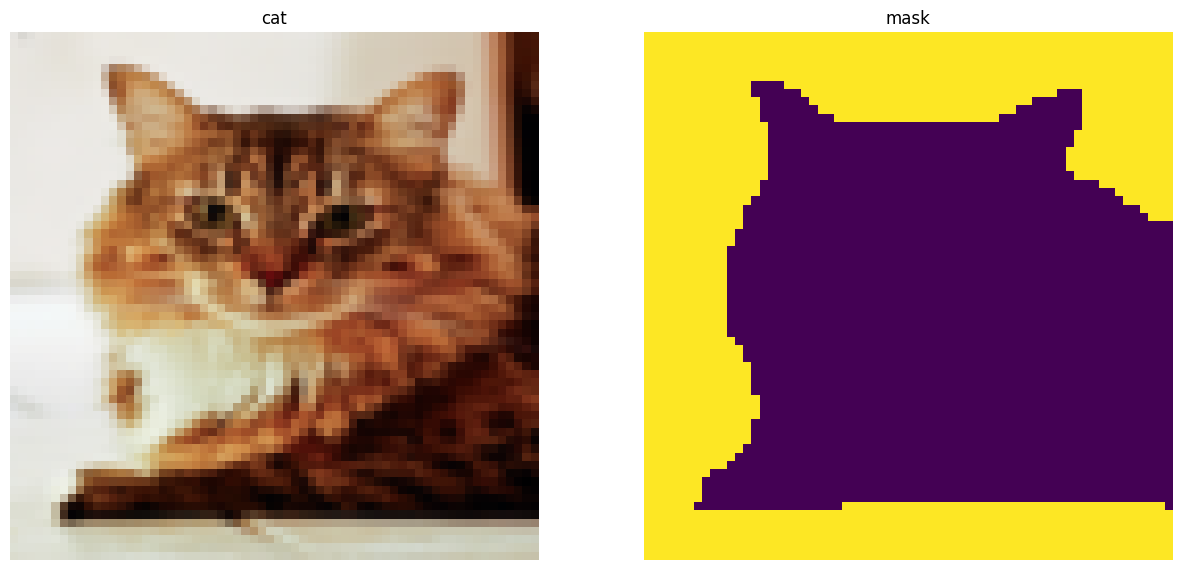

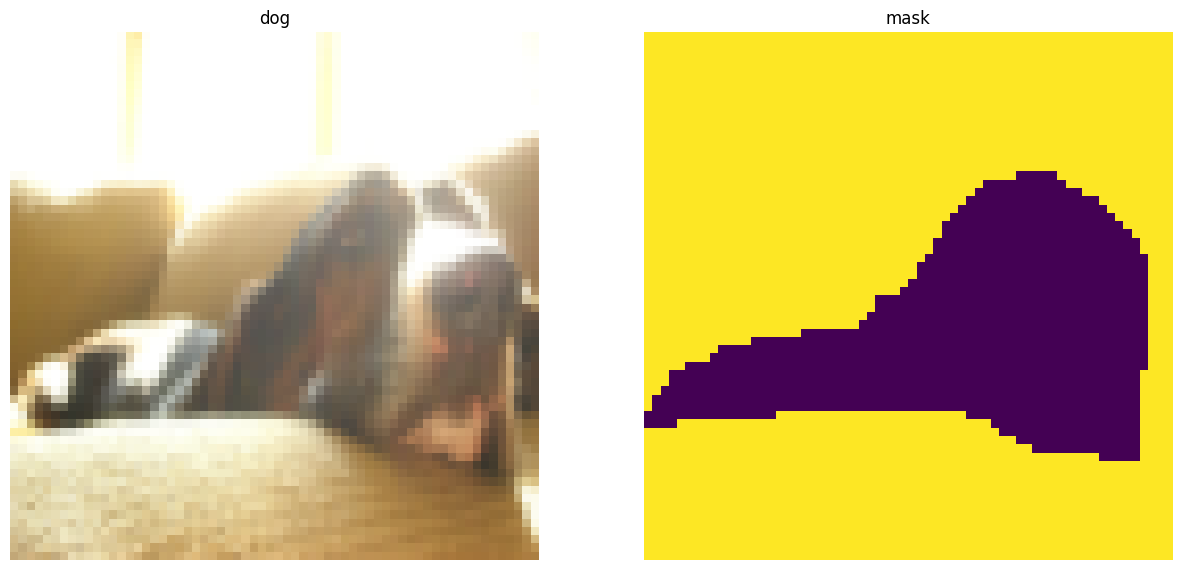

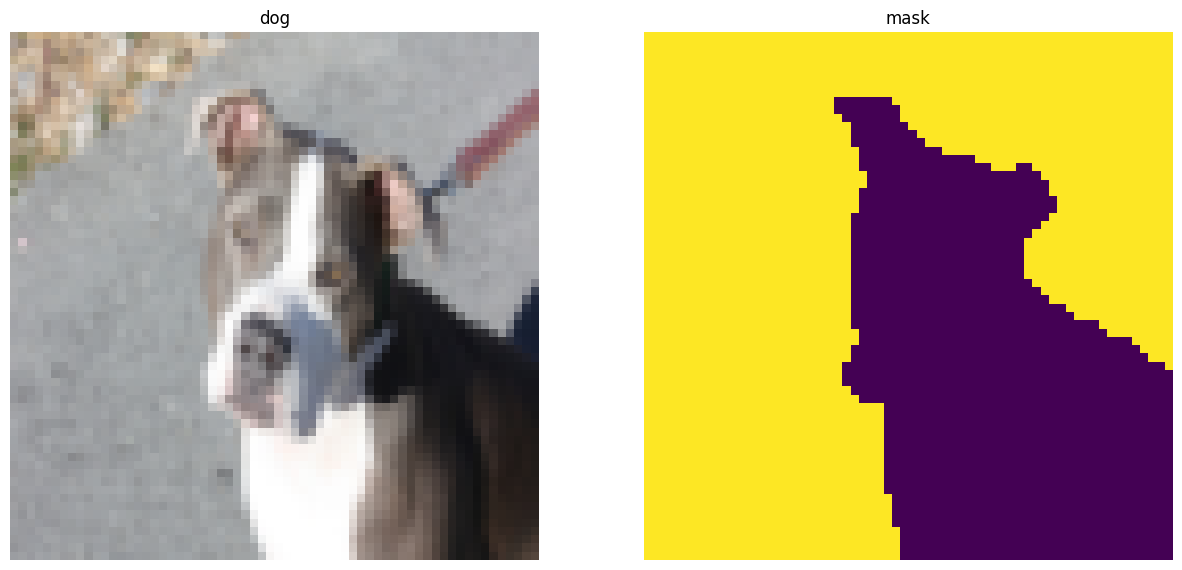

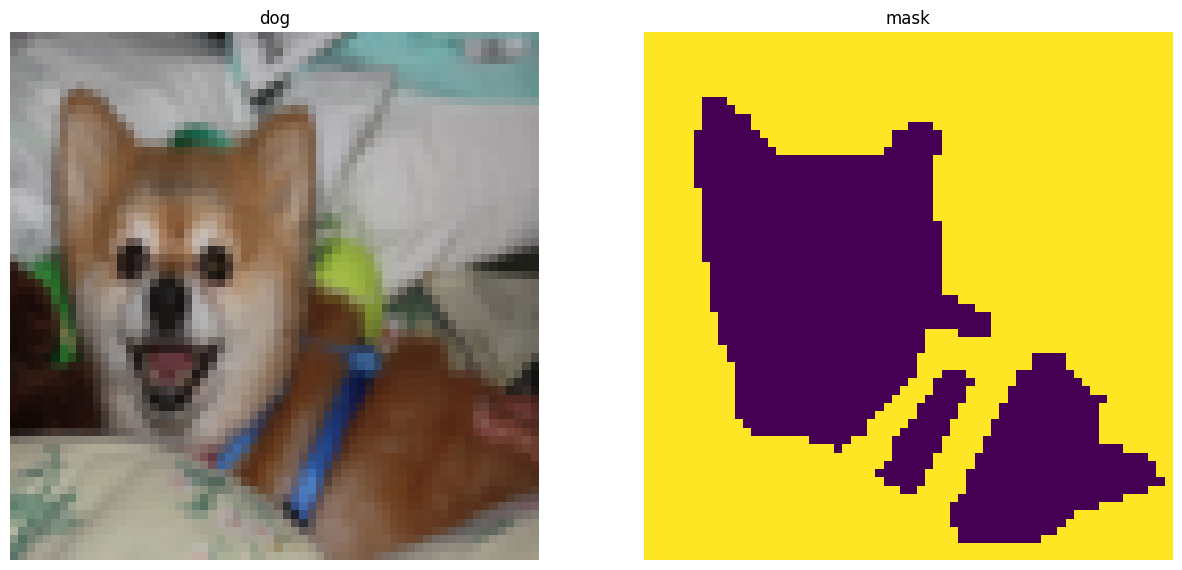

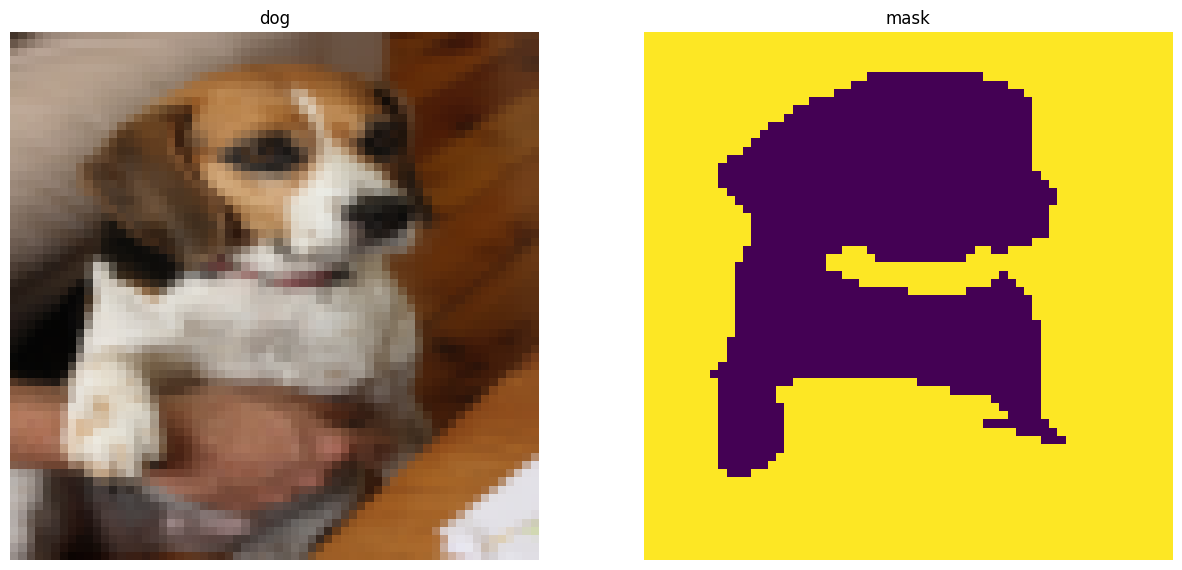

In [20]:
from matplotlib import pyplot as plt

number_of_rows = 5
for i in range(number_of_rows):
    img, (seg_mask, label) = test_data[np.random.randint(0, len(test_data))]
    figure = plt.figure(figsize=(15, 15))
    #Draw img
    figure.add_subplot(1, 2, 1)
    plt.title(label_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze().permute([1, 2, 0]))
    #Draw mask
    figure.add_subplot(1, 2, 2)
    plt.title("mask")
    plt.axis("off")
    plt.imshow(seg_mask.squeeze())
    plt.show()

# Exercise 1: Simple Convolutional Neural network (CNN)

In this execrise you are building a neural network to separate between cats and dogs. If you want, you can also try separating different breeds.


### Nearest neighbors in pixel space

For fun we can check out which images are close in pixel space. This means we will find images with similar colored pixels in the same location. Often generally dark images will match with dark images and visa-versa. This makes it clear that we cannot separate cat and dogs with a shallow classification algorithm in pixel space directly.

(400, 3, 64, 64)


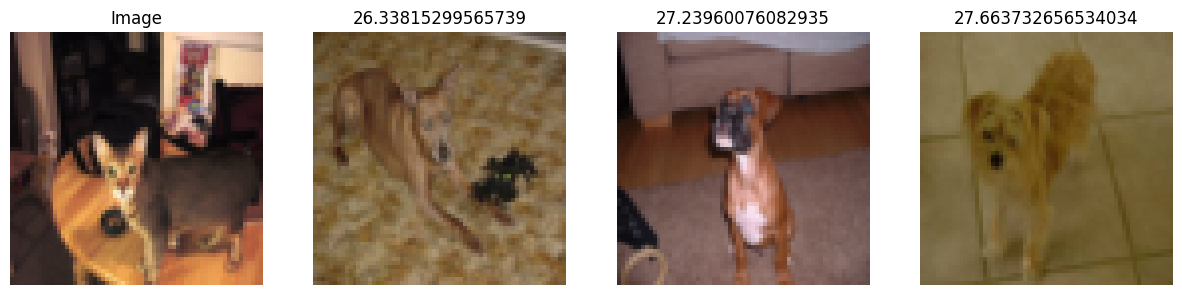

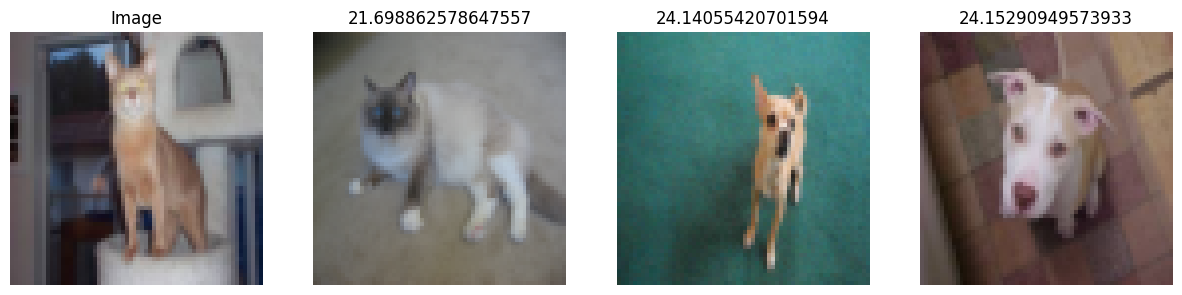

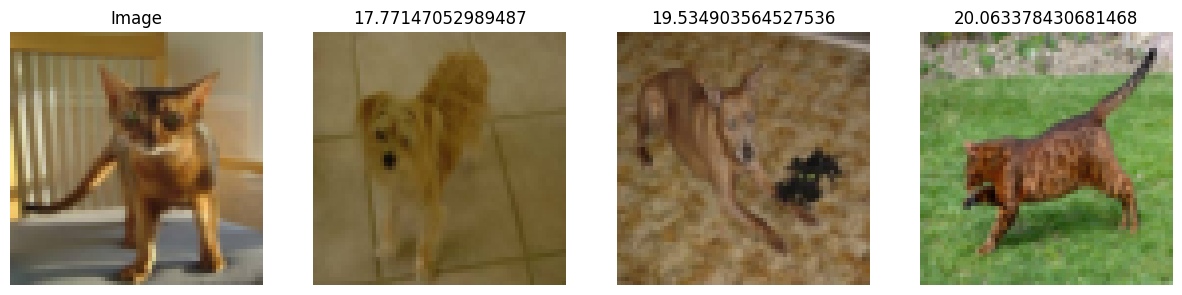

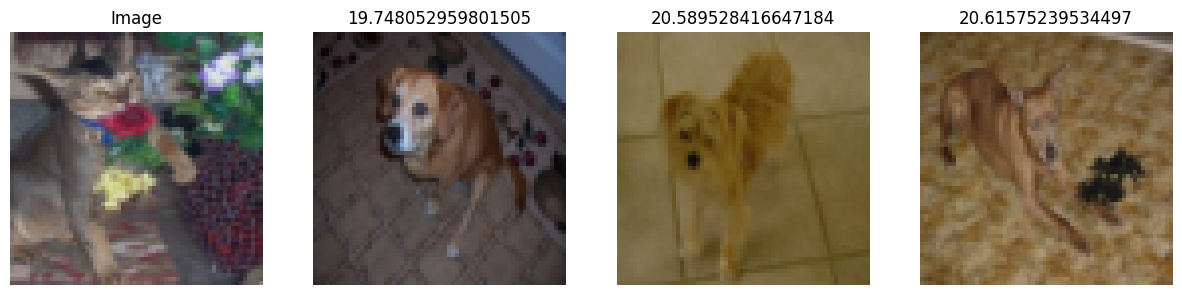

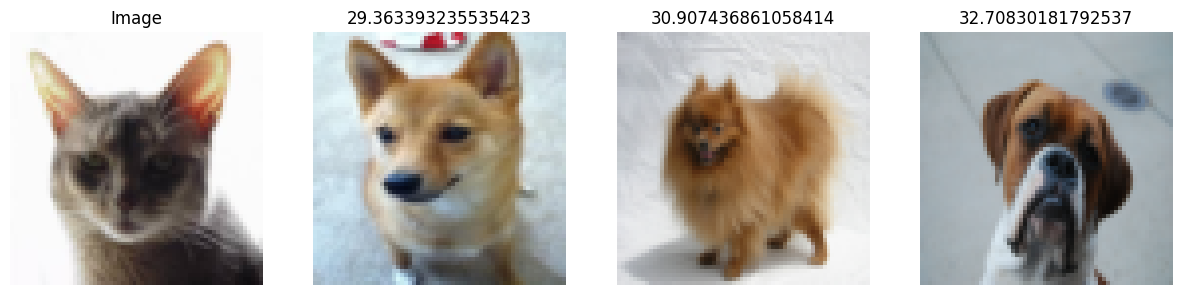

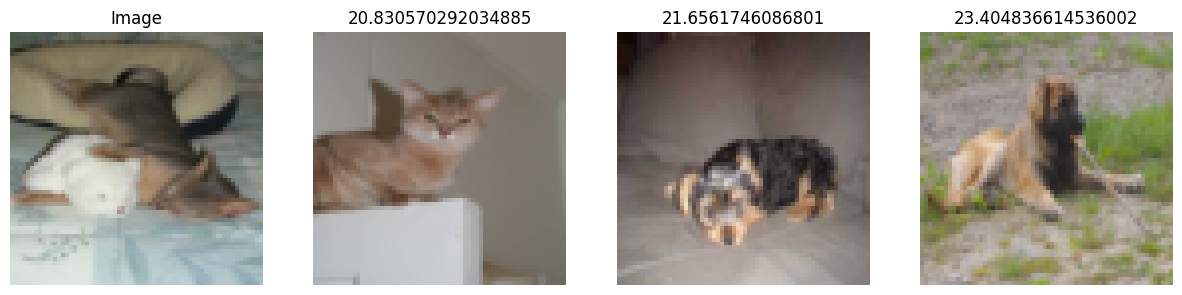

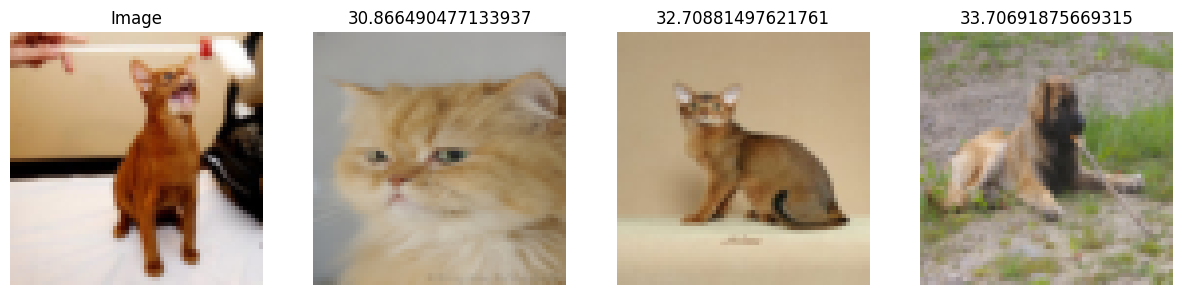

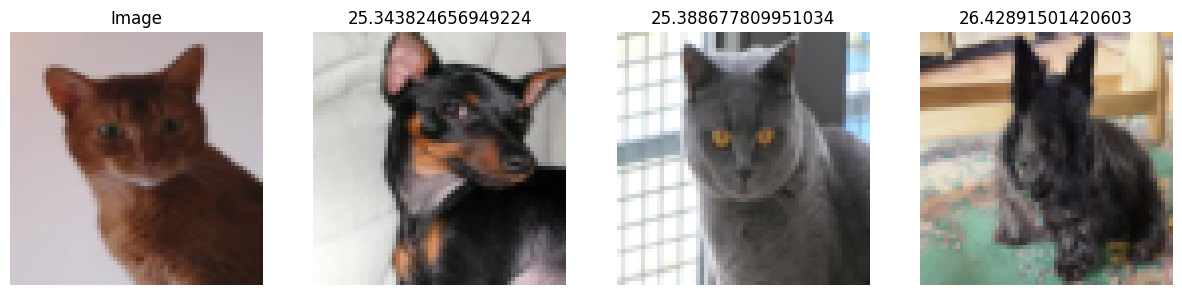

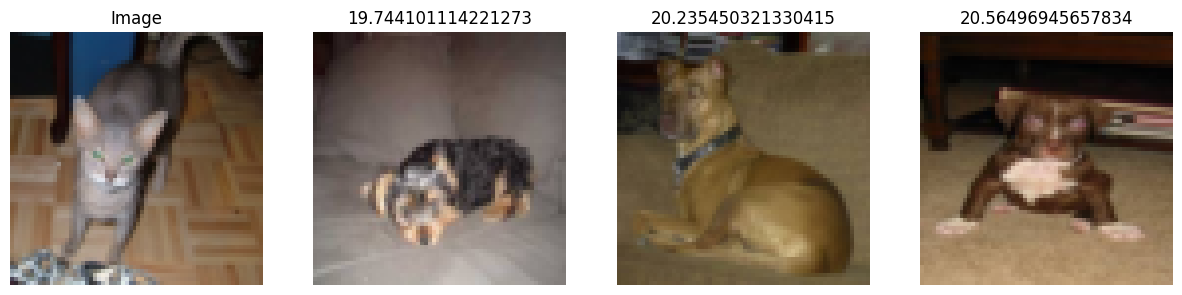

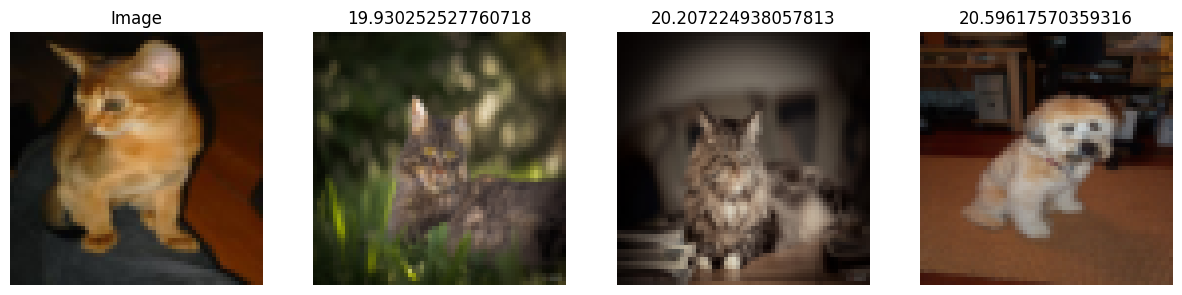

In [21]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot


def display(display_list, titles=None):
    """ Plotting images in list """
    from matplotlib import cm
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        if titles != None:
            plt.title(titles[i])
        plt.imshow(
            np.squeeze(display_list[i]).transpose((1, 2, 0)),
            vmin=0,
            vmax=1
        )
        plt.axis('off')
    plt.show()


# Pick the first 400 samples and take only the images of each sample
nn_loader = DataLoader(train_data, batch_size=400, shuffle=True)

# Extract the images to a numpy array of the 400 images of shape 200x3x128x128
X = next(iter(nn_loader))[0].numpy()
print(X.shape)

nbrs = NearestNeighbors(n_neighbors=3)
# Add images reshaped to vectors to nearest-neighbors tree
nbrs.fit(X.reshape([X.shape[0], -1]))

# Loop through 10 test images and display 3 nearest neighbors
for i, (image, (mask, label)) in enumerate(test_data):
    if i >= 10:
        break
    distances, indices = nbrs.kneighbors(image.numpy().reshape((1, -1)))
    show_img = display([
        image.numpy(),
        X[indices[0, 0]],
        X[indices[0, 1]],
        X[indices[0, 2]]
    ], ['Image'] + list(distances[0]))

## Fully-convolutional network
It's a good idea to implement the network as a fully-convolutional neural network. This means that the network will work for different input sizes.

A fully-convolutional network use no fully-connected layers (matrix multiplications). They often consist of mostly convolutional layers, but also include other operations that does not require fixed input size like: add, concatenations, max (relu), batch normalization etc.

## Torch Moule
I recommend using the Object-Oriented style of Torch Module, as it is the most flexible and are almost identical in both Keras/Tensorflow and PyTorch. In this approach you make subclass of [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=module#torch.nn.Module) and implement the **\_\_init\_\_** and **forward** method. In **\_\_init\_\_** you need to initialize everything that has state in your network, while **call** method actually run the network from output to input.

You can use [torch.nn.Convd2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), for the convolutions.

I also recommend using some pooling operations like [torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) or [torch.nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), or strides in the convolutions to get a larger field of view.

You can check out this tutorial [Build Model](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html), for pointer on how to implement a module.

**TODO:**
Fill out the *\_\_init\_\_* and *call* method with appropriate layers. Remember to use activation functions like [*ReLU*](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) between your convolutional layers, but do not apply an activation function after your final layer.

Try to use only a few layers 4-6 convolutional layers, to save computation and avoid problems with vanishing gradients. With many layers you would need to either be very careful with initialization and learning rate or use normalization layers like BatchNormalization.

The output of the *forward* function should have shape \[*batch_size*, *num_classes*\].

**If the "output_features" parameter is *True* you should output the result before the last convolutional layer.**

*[torch.mean](https://pytorch.org/docs/stable/generated/torch.mean.html#torch.mean) is used to average over the spatial dimension to get only one output vector for the whole image.*

In [38]:
import time

import numpy as np
import torch
from torch.nn import Conv2d, Linear, Dropout, AvgPool2d, MaxPool2d
from torch.nn.functional import relu, elu
import torchvision

class SimpleNet(torch.nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleNet, self).__init__()
        self.num_classes = num_classes

        # TODO: Initialize the layers of your network
        # You can find different layers in torch.nn (https://pytorch.org/docs/stable/nn.html)
        padding = 'same'
        self.pool = MaxPool2d((2, 2), stride=(2, 2))
        self.conv1 = torch.nn.Conv2d(3, 32, 5, padding=padding)
        self.conv2 = torch.nn.Conv2d(32, 64, 5, padding=padding)
        self.conv3 = Conv2d(64, 128, 5, padding=padding)
        self.conv4 = Conv2d(128, 128, 5, padding=padding)
        self.dropout = Dropout(0.5)
        self.conv5 = Conv2d(128, num_classes, 8, stride=1, padding='valid')

    def forward(self, x, output_features=False):
        # TODO: Run the image through your network
        # Your input should be a [Batch_size x 3 x 32 x 32] sized tensor
        # Your output should be a [Batch_size x num_classes] sized matrix
        x = elu(self.pool(self.conv1(x)))
        x = elu(self.conv2(x))
        x = elu(self.pool(self.conv3(x)))
        x = elu(self.conv4(x))
        # Output features of your second last layer
        if output_features: return x
        x = self.dropout(x)

        x = self.conv5(x)
        # Return the result of your network
        return torch.mean(x, dim=(2, 3))


# Initializing the model
NUM_CLASSES = 5
BATCH_SIZE = 8
model = SimpleNet(NUM_CLASSES)
# Running the model with 8 random 128x128x3 images
model_output = model(torch.from_numpy(np.random.random((BATCH_SIZE, 3, 128, 128)).astype(np.float32)))
print('Model output:', model_output)
print('Model output shape:', model_output.shape)

assert model_output.shape == (BATCH_SIZE, NUM_CLASSES), "Incorrect output size from call"

Model output: tensor([[ 0.0253,  0.0238, -0.0055,  0.0337,  0.0290],
        [ 0.0252,  0.0245, -0.0066,  0.0287,  0.0270],
        [ 0.0267,  0.0255, -0.0073,  0.0284,  0.0305],
        [ 0.0281,  0.0245, -0.0076,  0.0306,  0.0308],
        [ 0.0247,  0.0250, -0.0060,  0.0293,  0.0297],
        [ 0.0246,  0.0230, -0.0058,  0.0322,  0.0291],
        [ 0.0246,  0.0251, -0.0059,  0.0300,  0.0270],
        [ 0.0261,  0.0250, -0.0069,  0.0282,  0.0298]],
       grad_fn=<MeanBackward1>)
Model output shape: torch.Size([8, 5])


### Parameters
If your using the predefined modules from *torch.nn*, the parameters of the layers are automatically added to the modules parameters. The parameters are just tensors, but the register in a hieraki, so nested modules easiely can access all parameters.

If you want to use raw tensors as parameters for your model, you need to wrap your tensors in *torch.nn.parameter.Parameter*

```python
class MyModule(nn.Module):
  def __init__(self):
    super(MyModule, self).__init__()
    self.b = torch.nn.parameter.Parameter(torch.tensor(1))
```

You can iterate over parameters in a module as following:

In [32]:
print("Model structure: ", model, "\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")
# Initializing the mo

Model structure:  SimpleNet(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(2, 2), padding=valid)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=valid)
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=valid)
  (conv4): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=valid)
  (dropout): Dropout(p=0.5, inplace=False)
  (conv5): Conv2d(128, 5, kernel_size=(5, 5), stride=(1, 1), padding=valid)
) 


Layer: conv1.weight | Size: torch.Size([32, 3, 5, 5]) | Values : tensor([[[[-0.0835,  0.1153,  0.1074, -0.0763, -0.0779],
          [ 0.0884,  0.0736,  0.0547,  0.1131,  0.1049],
          [ 0.1028, -0.0220, -0.0261,  0.0464, -0.0607],
          [ 0.0626, -0.0442, -0.0672, -0.0410, -0.0032],
          [-0.0575,  0.0992,  0.1121, -0.0262, -0.0575]],

         [[-0.0322, -0.0875,  0.0449, -0.1028,  0.0667],
          [ 0.0837, -0.1124,  0.0084,  0.0179, -0.0595],
          [-0.0866, -0.0423,  0.0659,  0.0664,  0.0913],
          [-0.0955

### Training a Torch model
As we saw in [Automatic Differentiation](#Automatic-Differentiation) we can get the gradients with respect to a tensor after a backward. The tensor can also be updated with that gradient. Still this can be quite a hassel with many parameters/tensors.

PyTorch provide a simplified interface for this, with [torch.optim](https://pytorch.org/docs/stable/optim.html). An optimizer is initialized with the parameters or tensors it is supposed to optimize. With a torch.nn.Module this is simply done with e.g.:

```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
```

Calling *optimizer.step()* will then update the tensor based on the gradient information. Calling *optimizer.zero_grad()* will zero out all the gradients ahead of a new step. A training step could then be done as following:

```python
optimizer.zero_grad()
ouput = model(x)
loss = calculate_loss(x, target)
loss.backward()
optimizer.step()
```

In [torch.optim](https://pytorch.org/docs/stable/optim.html#algorithms) you can find many implementations of different optimization algorithms. They all subtrackt some scaled version of the gradients from the parameters, but use various information to decide the step-size/scale. For simple tests i prefere to use [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) as it is more robust to the input parameters than many of the other methods (you will need less parameter tuneing).

#### **Tips for training**
Start by training your network with just a small dataset, e.g. one batch. 

To check you have properly initialized your weights and scaled your inputs you can check your initial loss. Your initial loss should be roughly equal to *-ln(1/N)*, where N is the number of classes.

When training on a small version of your dataset your accuracy should steadily rise to 1. If it does not, you could try to adjust your learning rate. Your learning rate should generally be as high as possible, while still not increase your loss at the begining of your training.

Adam is often a good optimizer for quick tests, as it requires comparably less *tuning* of the learning rate.

You can quite easily calculate your own loss function, but for convinience you can use [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy).

**TODO**:
Train the network and evaluate that
Train the network to a decent test accuracy. The dataset are small so we cannot expect very good accuracy, additionally colab provide less resources than previously. Therefore **do not** expect a very good result, just better than random. Hopefully up to 70% acc, but move on sooner than later.

Remember to create your dataloaders by running the cells in [Datasets and dataloader](#Datasets-and-dataloader)

In [39]:
from torch.utils.data import DataLoader

NUM_EPOCHS = 6
model = SimpleNet(num_classes=2).to(device)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=6)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=1)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)

calculate_loss = torch.nn.CrossEntropyLoss()
print(len(train_data))
img, (seg_mask, label) = next(iter(train_dataloader))
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    tic = time.time()

    model.dropout.training = True
    for i, (img, (seg_mask, label)) in enumerate(train_dataloader):
        optimizer.zero_grad()
        img, label = img.to(device), label.to(device)
        out = model(img)
        loss = calculate_loss(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f, time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10, time.time() - tic))
            running_loss = 0.0
            tic = time.time()
    loss_accum = 0
    acc_accum = 0
    cnt = 0
    model.dropout.training = False
    for inputs_test, (seg_mask, labels_test) in test_dataloader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        with torch.no_grad():
            test_output = model(inputs_test)
            test_loss = calculate_loss(test_output, labels_test)
        test_acc = (test_output.argmax(1) == labels_test).double().mean()
        loss_accum += test_loss.detach()
        acc_accum += test_acc.detach()
        cnt += 1
    print('TEST [%d, %5d] loss: %.3f, acc: %.3f' %
          (epoch + 1, i + 1, loss_accum / cnt, acc_accum / cnt))

    #TODO: Optimize your network

3680
[1,    10] loss: 1.740, time: 0.671
[1,    20] loss: 0.668, time: 0.380
[1,    30] loss: 0.700, time: 0.477
[1,    40] loss: 0.677, time: 0.241
[1,    50] loss: 0.684, time: 0.356
[1,    60] loss: 0.699, time: 0.308
[1,    70] loss: 0.671, time: 0.193
[1,    80] loss: 0.664, time: 0.318
[1,    90] loss: 0.666, time: 0.389
[1,   100] loss: 0.626, time: 0.249
[1,   110] loss: 0.642, time: 0.284
TEST [1,   115] loss: 0.642, acc: 0.658
[2,    10] loss: 0.634, time: 0.762
[2,    20] loss: 0.637, time: 0.358
[2,    30] loss: 0.649, time: 0.210
[2,    40] loss: 0.661, time: 0.277
[2,    50] loss: 0.638, time: 0.305
[2,    60] loss: 0.688, time: 0.227
[2,    70] loss: 0.646, time: 0.336
[2,    80] loss: 0.652, time: 0.343
[2,    90] loss: 0.665, time: 0.208
[2,   100] loss: 0.646, time: 0.299
[2,   110] loss: 0.604, time: 0.227
TEST [2,   115] loss: 0.624, acc: 0.663
[3,    10] loss: 0.656, time: 0.551
[3,    20] loss: 0.651, time: 0.315
[3,    30] loss: 0.659, time: 0.220
[3,    40] loss

### Visualizing nearest neighbor in feature space

The neural network transforms the input so that cats and dogs can be separated. Generally ths will make cat be close to cats and dogs be close to dogs. We can often also see that close object share some characteristics.

XSHAPE (400, 128, 16, 16)


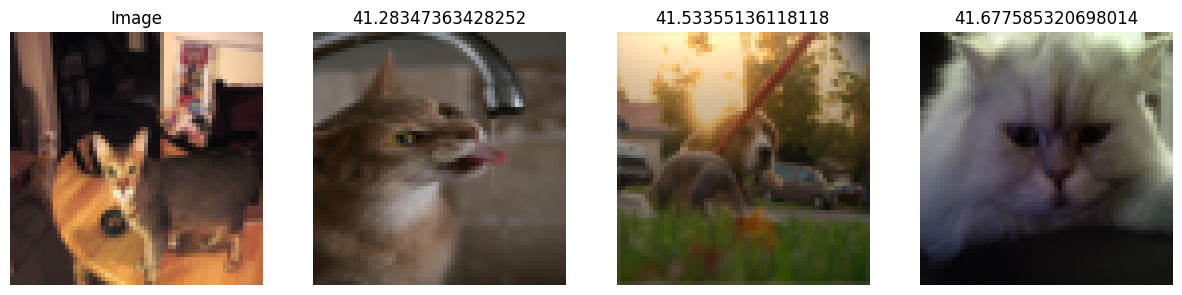

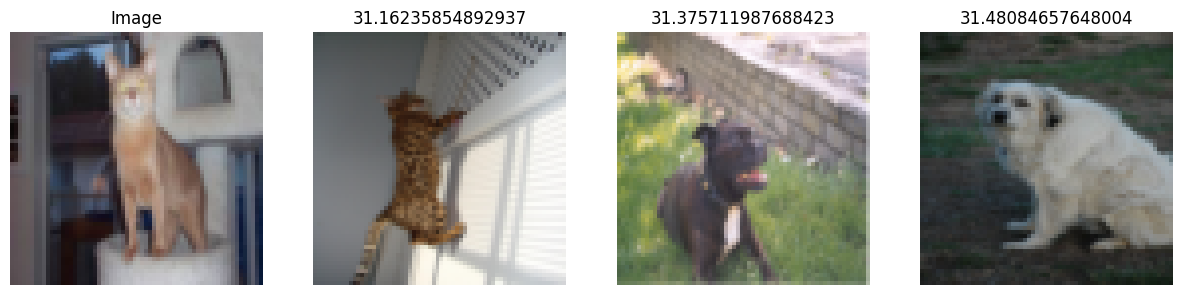

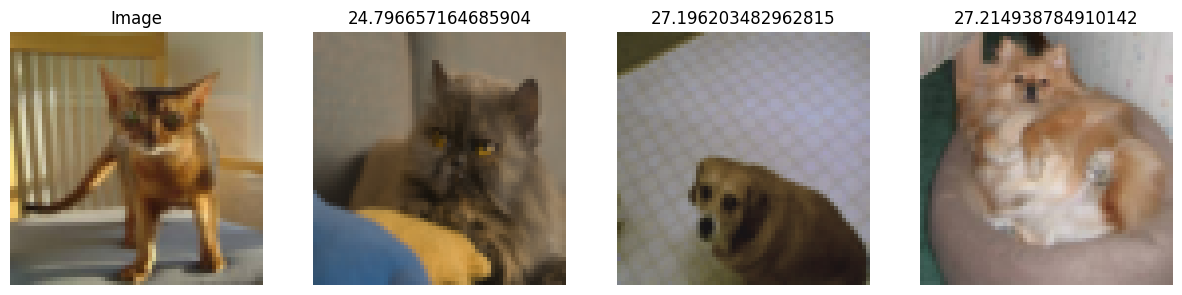

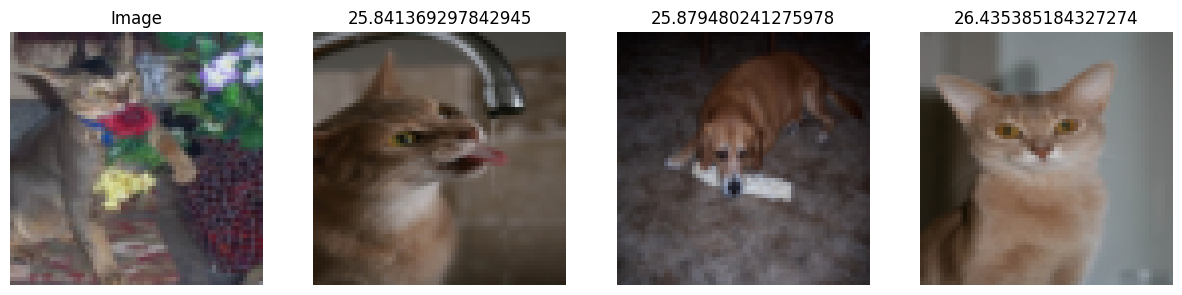

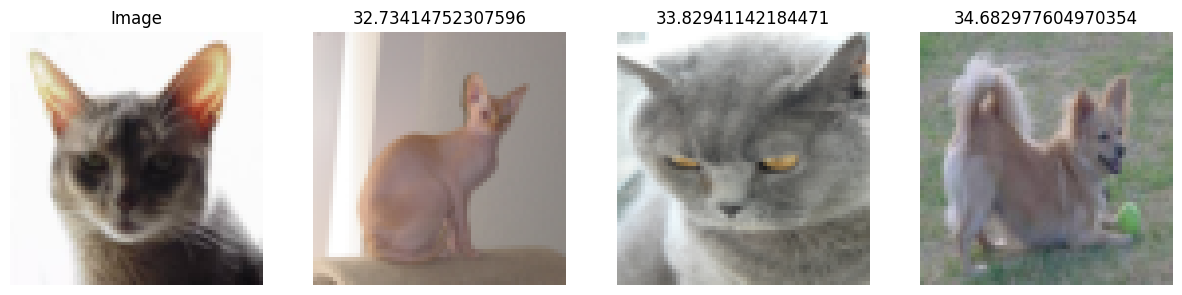

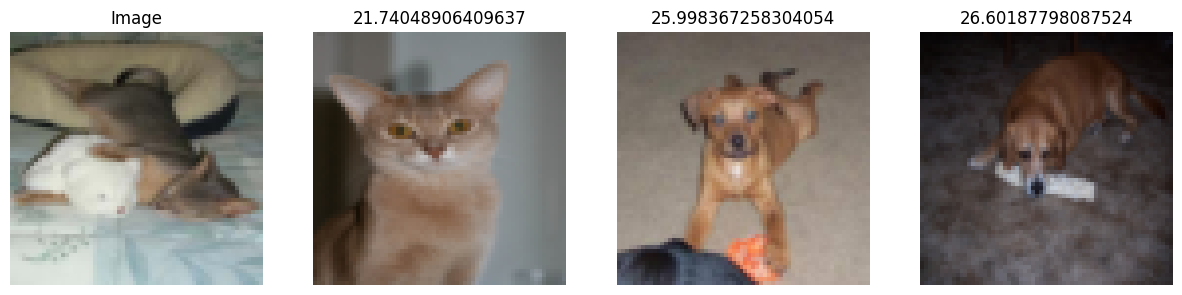

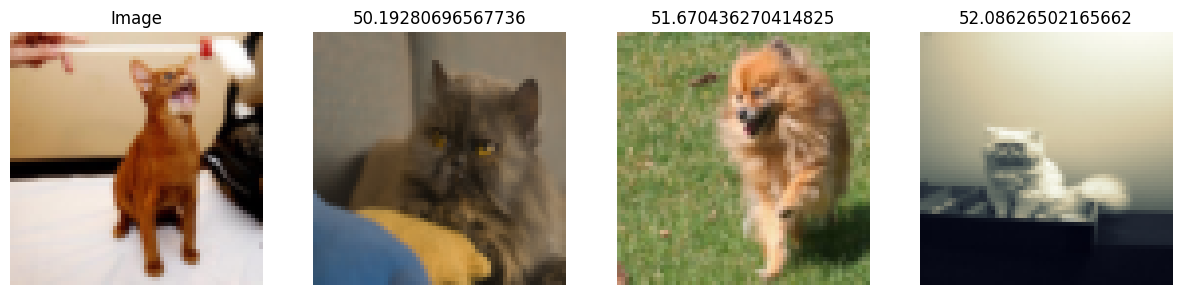

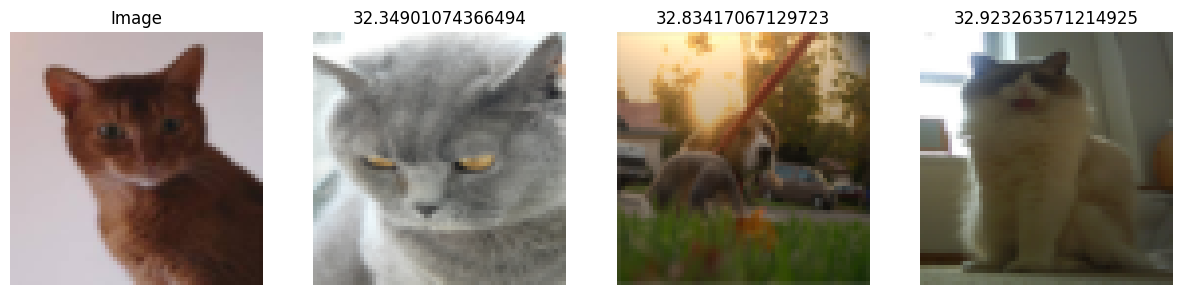

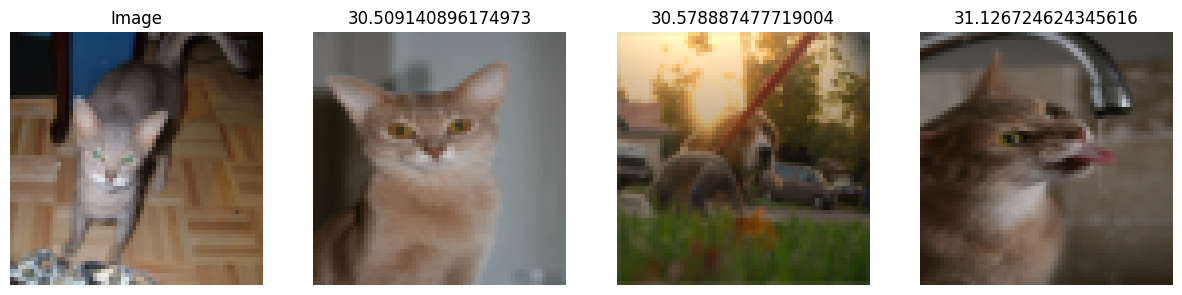

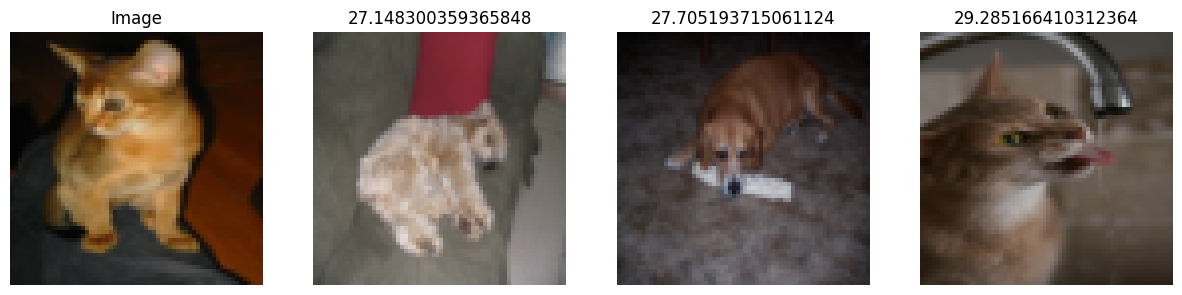

In [22]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot

import numpy as np

# Pick the first 400 samples and take only the images of each sample
nn_loader = DataLoader(train_data, batch_size=400, shuffle=True)

# Extract the images to a numpy array of the 400 images of shape 200x3x128x128
images_np = next(iter(nn_loader))[0].numpy()

# Extract the images to a numpy array of the 200 images of shape 200x128x128x3
X = model(torch.tensor(images_np).to(device), output_features=True).detach().cpu().numpy()

nbrs = NearestNeighbors(n_neighbors=3)
# Add images reshaped to vectors to nearest-neighbors tree
print('XSHAPE', X.shape)
nbrs.fit(X.reshape([X.shape[0], -1]))

# Loop through 10 test images and display 3 nearest neighbors
cnt = 0
for image, (mask, label) in test_data:
    if cnt == 10:
        break
    cnt += 1
    distances, indices = nbrs.kneighbors(
        model(image[None].to(device), output_features=True).detach().cpu().numpy().reshape((1, -1)))
    show_img = display([
        image.numpy(),
        images_np[indices[0, 0]],
        images_np[indices[0, 1]],
        images_np[indices[0, 2]]
    ], ['Image'] + list(distances[0]))

### Visualizing [GRAD-CAM](http://openaccess.thecvf.com/content_ICCV_2017/papers/Selvaraju_Grad-CAM_Visual_Explanations_ICCV_2017_paper.pdf)

There are many techniques for visualizing what is going on inside a neural network.

The technique use the gradients of the output label with respect to the image in combination with the values of the activation map. With this information we can plot what regions of the input that are pointing toward a given label.

We would e.g. expect that a cat would light up if we used the cat label for as input to Grad-CAM.

With this technique we can check if the network actually use relvant information in the classification process and are not overfitted.

Since the output is normalized, it will always highlight some regions. If the surroundings is highlighted it may simply mean that it found nothing "doglike" in the image.

We use the visualization tool [Captum](https://captum.ai/) for visualization.

In [ ]:
#Install the visualization tool
!pip install captum

torch.Size([64, 64])


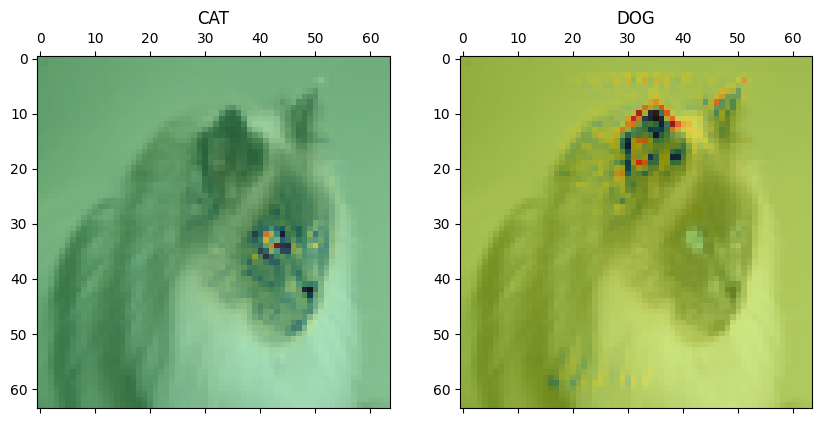

CAT: 0.9151402115821838
torch.Size([64, 64])


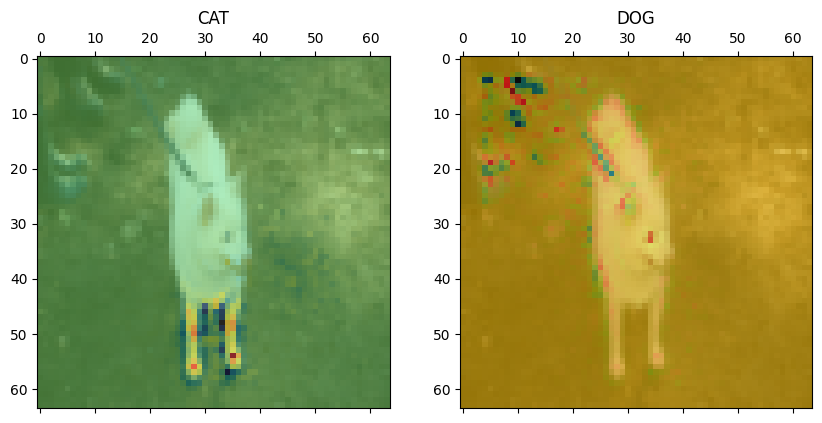

DOG: 0.880097508430481
torch.Size([64, 64])


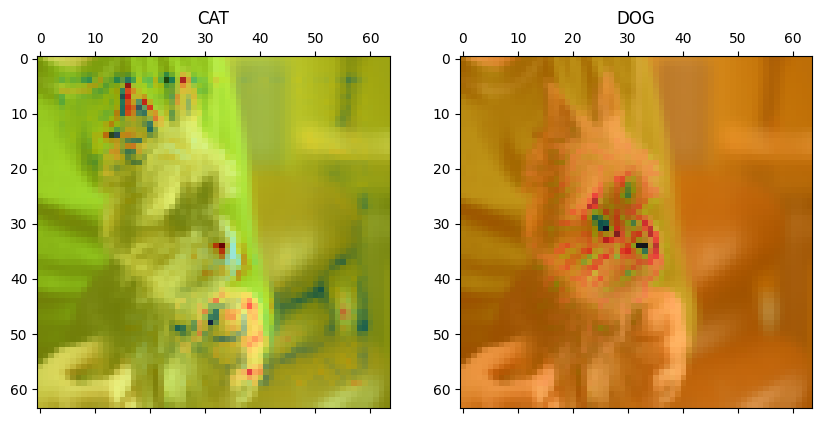

DOG: 0.661201000213623
torch.Size([64, 64])


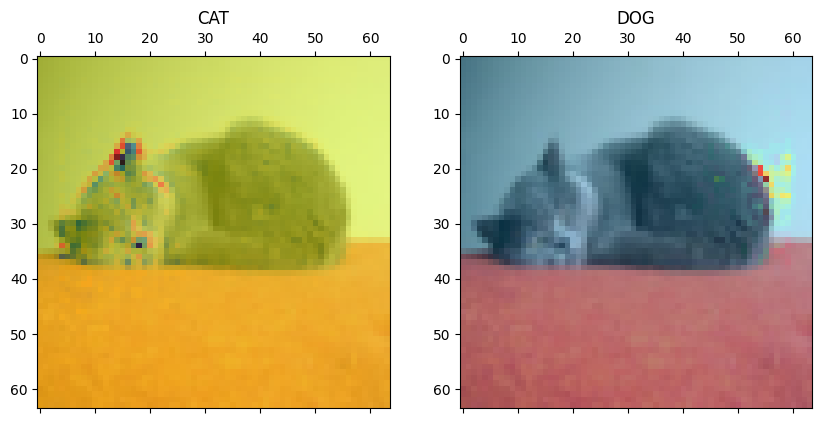

CAT: 0.9335947036743164
torch.Size([64, 64])


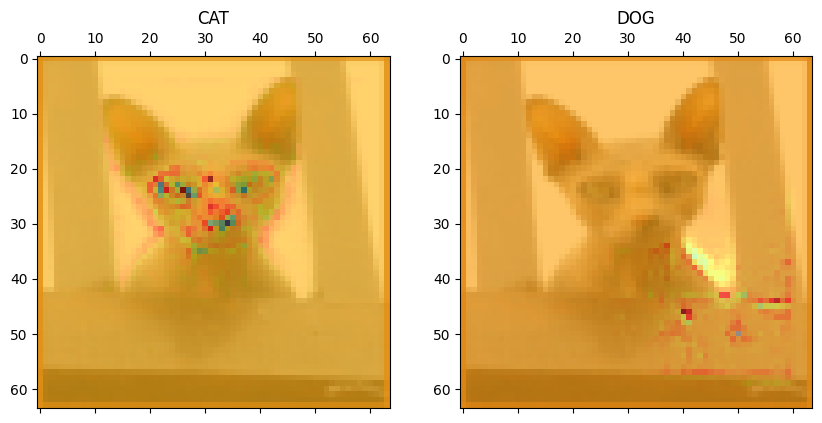

CAT: 0.9966018199920654
torch.Size([64, 64])


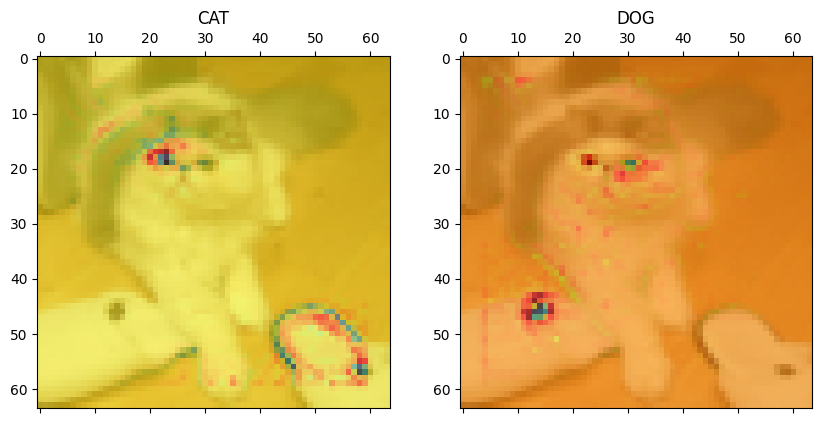

DOG: 0.7502029538154602
torch.Size([64, 64])


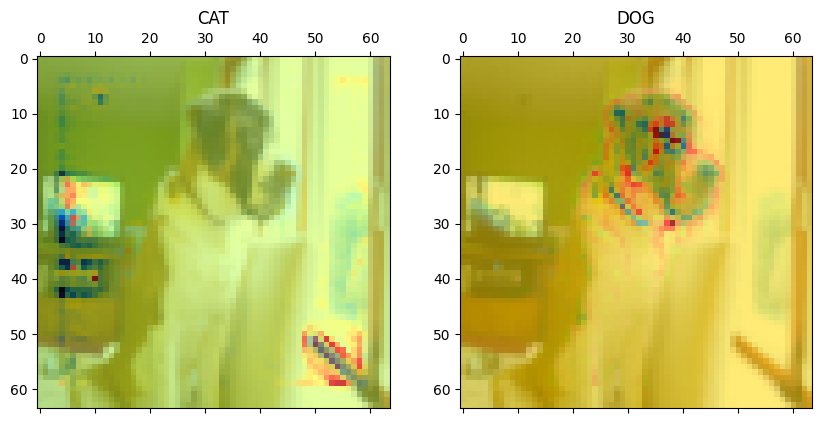

DOG: 0.911532461643219
torch.Size([64, 64])


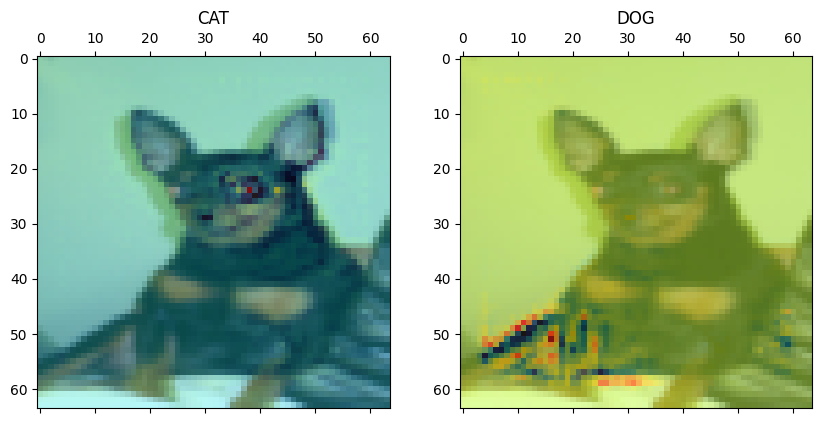

CAT: 0.8222520351409912
torch.Size([64, 64])


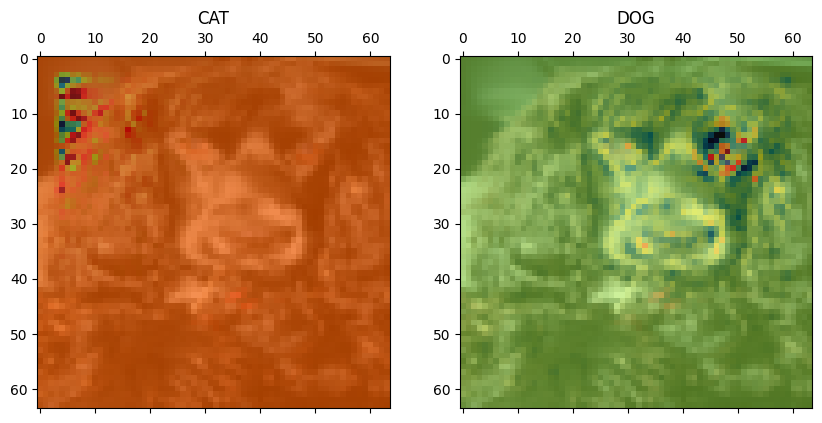

DOG: 0.9932997226715088
torch.Size([64, 64])


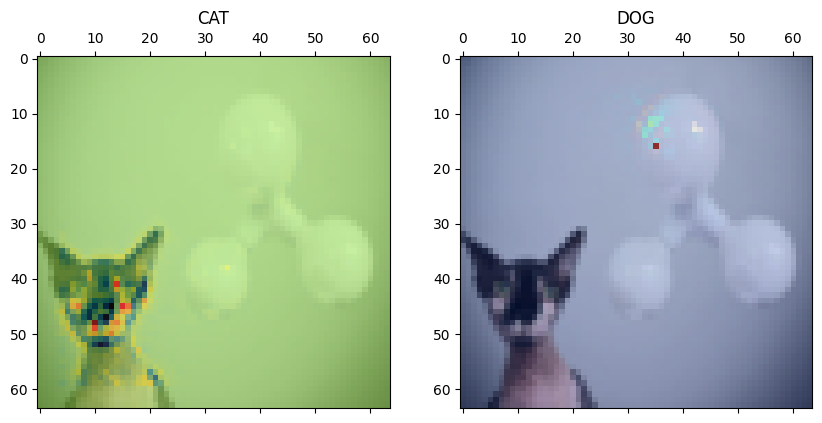

CAT: 0.9812270402908325


In [51]:
from captum import attr
from captum.attr import GuidedGradCam

#Create gradcam for model
#TODO: input model and models last layer
gradcam = GuidedGradCam(model_fine, model_fine.base_model.layer4)

cnt = 0
label_map = ['CAT', 'DOG']

for idx in np.random.choice(len(test_data), 10):
    image, (mask, label) = test_data[idx]
    if cnt == 10:
        break
    cnt += 1
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].imshow(image.permute(1, 2, 0).numpy())
    ax[1].imshow(image.permute(1, 2, 0).numpy())
    out = model_fine(image[None].to(device)).softmax(1).detach()
    image.requires_grad = True
    attr_cat = gradcam.attribute(image[None].to(device), 0, interpolate_mode='bicubic').mean((0, 1)).detach().cpu()
    attr_dog = gradcam.attribute(image[None].to(device), 1, interpolate_mode='bicubic').mean((0, 1)).detach().cpu()
    print(attr_cat.shape)
    attr_cat -= attr_cat.min()
    attr_cat /= attr_cat.max() + 1e-8
    attr_dog -= attr_dog.min()
    attr_dog /= attr_dog.max() + 1e-8

    ax[0].set_title('CAT')
    ax[1].set_title('DOG')

    ax[0].matshow(attr_cat, cmap='jet', alpha=0.8 * attr_cat)
    ax[1].matshow(attr_dog, cmap='jet', alpha=0.8 * attr_dog)

    plt.show()
    print(f'{label_map[out[0].argmax()]}: {out.max()}')


### Finetuning a network
You can quite easily download and run a pretrained network. Using a network that is trained on a similar, but larger dataset will often improve your result. Using a network pretrained on the ImageNet dataset will definetly work, as the dataset already includes different types of dogs and cats.

You can e.g. load a pretrained network like this:

    from torchvision import models
    net = models.resnet18(True)

Here we exclude the top classification layer, as we want a different number of classes. So we have to make this layer for our self.

Now the network can be used similar to a Conv2d layer. If you have a small dataset or few computational resourses, you can freeze the network parameters in the pretrained network like this:

    for param in net.parameters():
        param.requires_grad = False
    
Since the network is trained on ImageNet with a 1000 classes, your loaded network will have 1000 outputs. There are two common options to fix this.

1. The simplest way is to override the networks fc layer e.g. like this:
```
num_ftrs  = self.base_model.fc.in_features
net.fc = Linear(512, num_classes)
```

2. Another more flexible, but more complicated method is to just use the pretrained modules submodules directly in your forward function.

```python
def forward(self, x):
  x = self.net.conv1(x)
  x = self.net.bn1(x)
  ...
```

Here you have to look into how the base networks original forward function works.

**TODO:**
Use a pretrained network as a start of your model and create only the last layers. Train only the layers you have created.

In [37]:
import time
import torch.optim as optim
from torchvision import datasets, models, transforms
import torch.nn.functional as F
import torch.nn as nn
import torch
import os


class FinetuneNet(nn.Module):
    def __init__(self, num_classes=10):
        super(FinetuneNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Initialize the layers of your network
        weights = models.ResNet18_Weights.DEFAULT
        self.base_model = models.resnet18(weights=weights)
        self.transforms = weights.transforms()
        self.base_model.eval()
        for param in self.base_model.parameters():
            param.requires_grad = False
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x, output_features=False):
        # TODO: Run the image through your network
        # Your input should be a [Batch_size x 3 x 32 x 32] sized tensor
        # Your output should be a [Batch_size x num_classes] sized matrix
        x = self.base_model(self.transforms(x))
        if output_features: return x
        # Return the result of your network
        return x


# Initializing the model
NUM_CLASSES = 5
BATCH_SIZE = 8
model_fine = FinetuneNet(NUM_CLASSES).to(device)
# Running the model with 8 random 128x128x3 images
model_output = model_fine(torch.rand((BATCH_SIZE, 3, 128, 128)).to(device))
print('Model output:', model_output)
print('Model output shape:', model_output.shape)

assert model_output.shape == (BATCH_SIZE, NUM_CLASSES), "Incorrect output size from call"

Model output: tensor([[ 0.3191, -0.2061,  0.4427,  0.3078, -0.0081],
        [ 0.4094, -0.0913,  0.3835,  0.1646,  0.0392],
        [ 0.3946, -0.1476,  0.4546,  0.1974,  0.2210],
        [ 0.3164, -0.1791,  0.3967,  0.3180,  0.1329],
        [ 0.4023, -0.2119,  0.4193,  0.2610,  0.0571],
        [ 0.3266, -0.1560,  0.4932,  0.3016,  0.0449],
        [ 0.2689, -0.2051,  0.4435,  0.3212,  0.1569],
        [ 0.4721, -0.1188,  0.3534,  0.2848,  0.0901]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
Model output shape: torch.Size([8, 5])


**TODO:**

Train your new network.

This should give a lot better performance, at least 0.75 in test accuracy!

You can re-run the visualization code, with this model. This should give a better clustering of dog and cats, and even cluster different breeds.

**TODO:** Initialize and finetune your model

In [42]:
# TODO: Initialize and finetune your model
NUM_EPOCHS = 6
model_fine = FinetuneNet(num_classes=2).to(device)
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False)
optimizer = torch.optim.AdamW(model_fine.parameters(), lr=0.001)

calculate_loss = torch.nn.CrossEntropyLoss()
print(len(train_data))
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    tic = time.time()

    for i, (img, (seg_mask, label)) in enumerate(train_dataloader):
        optimizer.zero_grad()
        img, label = img.to(device), label.to(device)
        out = model_fine(img)
        loss = calculate_loss(out, label)
        loss.backward()
        optimizer.step()
        running_loss += loss
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f, time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10, time.time() - tic))
            running_loss = 0.0
            tic = time.time()
    loss_accum = 0
    acc_accum = 0
    cnt = 0
    for inputs_test, (seg_mask, labels_test) in test_dataloader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)
        with torch.no_grad():
            test_output = model_fine(inputs_test)
            test_loss = calculate_loss(test_output, labels_test)
        test_acc = (test_output.argmax(1) == labels_test).double().mean()
        loss_accum += test_loss.detach()
        acc_accum += test_acc.detach()
        cnt += 1
    print('TEST [%d, %5d] loss: %.3f, acc: %.3f' %
          (epoch + 1, i + 1, loss_accum / cnt, acc_accum / cnt))

3680
[1,    10] loss: 0.590, time: 0.974
[1,    20] loss: 0.453, time: 1.066
[1,    30] loss: 0.376, time: 0.985
[1,    40] loss: 0.329, time: 1.030
[1,    50] loss: 0.307, time: 0.981
[1,    60] loss: 0.266, time: 0.991
[1,    70] loss: 0.280, time: 1.000
[1,    80] loss: 0.282, time: 0.994
[1,    90] loss: 0.242, time: 0.974
[1,   100] loss: 0.221, time: 1.075
[1,   110] loss: 0.250, time: 0.986
TEST [1,   115] loss: 0.202, acc: 0.925
[2,    10] loss: 0.219, time: 0.990
[2,    20] loss: 0.208, time: 1.027
[2,    30] loss: 0.194, time: 1.013
[2,    40] loss: 0.232, time: 0.984
[2,    50] loss: 0.193, time: 0.985
[2,    60] loss: 0.191, time: 0.964
[2,    70] loss: 0.230, time: 0.974
[2,    80] loss: 0.173, time: 0.997
[2,    90] loss: 0.187, time: 0.980
[2,   100] loss: 0.203, time: 1.061
[2,   110] loss: 0.216, time: 1.040
TEST [2,   115] loss: 0.167, acc: 0.935
[3,    10] loss: 0.164, time: 1.053
[3,    20] loss: 0.158, time: 0.986
[3,    30] loss: 0.219, time: 0.974
[3,    40] loss

#Exercise 3: Segmentation
We use the same dataset as in Exercise 1, but now instead of classifying dogs vs. cats, we try to output a segmentation mask. In other words simply classify each pixel, for this dataset simply into animal and not animal.

First we load the dataset, just as last time.

## Creating a segmentation network

A segmentation network is very similar to a classification network, except that your output need to be in the same spatial dimentions as your input.

### Simple segmentation network
The simplest way of doing this is to run a fully-convolutional network (only convolutionas and …Batch-size\*C\*N\*M, then N and M should be larger than 1 (probably N, M > 5).

You will probably get best results by using a pretrained network, but then you may need to use the second method of rewriting the *forward* function.

I use [torch.nn.functional.interpolate](https://pytorch.org/docs/stable/generated/torch.nn.functional.interpolate.html) to resize the output of the network. This implements gradients, so we can run backpropagation through the function.

## Loss function
A typical approach is to let your network output a classification for each pixel. So instead of your network outputting a tensor of shape (N, K), you output a tensor of shape (N, K, H, W). Here N is the number of input images, K is the number of classes, while H and W are height and width.

Each output along the K dimension should then represent the loglikelihood of a given class, for that pixel.

Luckily both [torch.nn.functional.cross_entropy](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy.html#torch.nn.functional.binary_cross_entropy)and [torch.nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) support arbitrary tensor size.

In [52]:
import time

import cv2
import numpy as np
import torch
from torch.nn import Conv2d, Linear, Dropout
from torch.nn.functional import interpolate
from torch.nn.functional import relu


class SimpleSegNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleSegNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Initialize the layers of your network
        # You can find different layers in torch.nn
        self.conv1 = Conv2d(3, 32, 5, stride=2, padding='valid')
        self.conv2 = Conv2d(32, 64, 5, stride=2, padding='valid')
        self.conv3 = Conv2d(64, num_classes, 5, stride=2, padding='valid')

    def forward(self, x, output_features=False):
        in_size = x.shape
        # TODO: Run the image through your network
        # Your input should be a [Batch_size x 3 x 32 x 32] sized tensor
        # Your output should be a [Batch_size x num_classes] sized matrix
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = self.conv3(x)
        # Output features of your second last layer
        if output_features: return x

        # Return the result of your network
        return interpolate(x, in_size[2:4], mode='bilinear')

    @staticmethod
    def compute_loss(pred, label):
        return torch.mean((pred - label) ** 2)

In [89]:
NUM_EPOCHS = 3
seg_model = USegNet(2).to(device)# SimpleSegNet(num_classes=2).to(device)
model_fine = None
model = None
running_loss = 0.0
optimizer = torch.optim.AdamW(seg_model.parameters(), lr=0.005)

calculate_loss = torch.nn.CrossEntropyLoss()
for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    tic = time.time()

    for i, (img, (seg_mask, label)) in enumerate(train_dataloader):
        optimizer.zero_grad()
        img, seg_mask = img.to(device), seg_mask.to(device)
        out = seg_model(img)
        loss = calculate_loss(out, seg_mask[:, 0].to(torch.int64))
        loss.backward()
        optimizer.step()
        running_loss += loss.detach()
        if i % 10 == 9:  # print every 10 mini-batches
            print('[%d, %5d] loss: %.3f, time: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10, time.time() - tic))
            running_loss = 0.0
            tic = time.time()
    test_losses = []
    test_accs = []
    for inputs_test, (seg_mask, labels_test) in test_dataloader:
        inputs_test, seg_mask = inputs_test.to(device), seg_mask.to(device)
        with torch.no_grad():
            test_output = seg_model(inputs_test)
            test_losses.append(calculate_loss(test_output, seg_mask[:, 0].to(torch.int64)).cpu().numpy())
            test_accs.append((test_output.argmax(1) == seg_mask).double().mean().cpu().numpy())
    print('TEST [%d, %5d] loss: %.3f, acc: %.3f' %
          (epoch + 1, i + 1, np.mean(test_losses), np.mean(test_accs)))


[1,    10] loss: 0.252, time: 1.002
[1,    20] loss: 0.268, time: 1.028
[1,    30] loss: 0.252, time: 1.060
[1,    40] loss: 0.259, time: 0.968
[1,    50] loss: 0.261, time: 0.985
[1,    60] loss: 0.242, time: 0.977
[1,    70] loss: 0.251, time: 1.046
[1,    80] loss: 0.264, time: 1.036
[1,    90] loss: 0.256, time: 1.037
[1,   100] loss: 0.249, time: 1.017
[1,   110] loss: 0.237, time: 1.016
TEST [1,   115] loss: 0.253, acc: 0.704
[2,    10] loss: 0.253, time: 1.014
[2,    20] loss: 0.251, time: 1.105
[2,    30] loss: 0.235, time: 1.028
[2,    40] loss: 0.257, time: 1.063
[2,    50] loss: 0.243, time: 1.055
[2,    60] loss: 0.227, time: 1.046
[2,    70] loss: 0.242, time: 1.018
[2,    80] loss: 0.245, time: 1.016
[2,    90] loss: 0.257, time: 1.031
[2,   100] loss: 0.240, time: 0.983
[2,   110] loss: 0.241, time: 1.036
TEST [2,   115] loss: 0.248, acc: 0.711
[3,    10] loss: 0.232, time: 0.986
[3,    20] loss: 0.256, time: 1.067
[3,    30] loss: 0.235, time: 1.004
[3,    40] loss: 0.2

## Visualizing your result

**TODO**: Inside the loop iterating through the test data, run your model and plot the result.

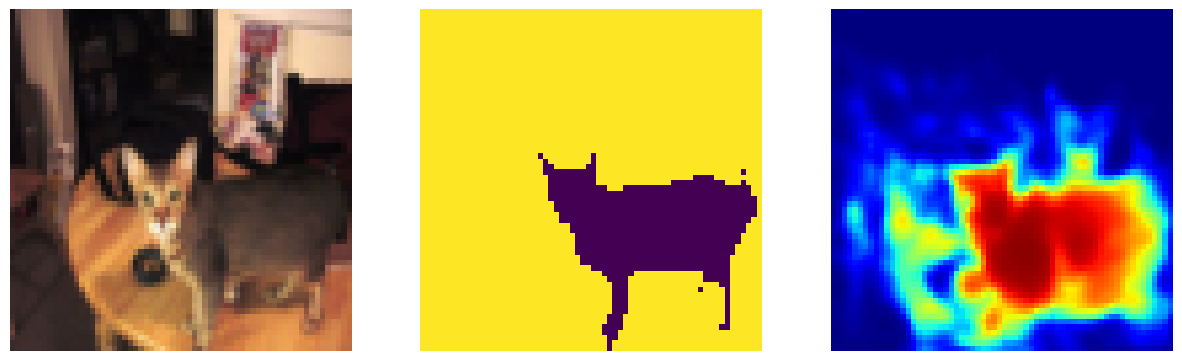

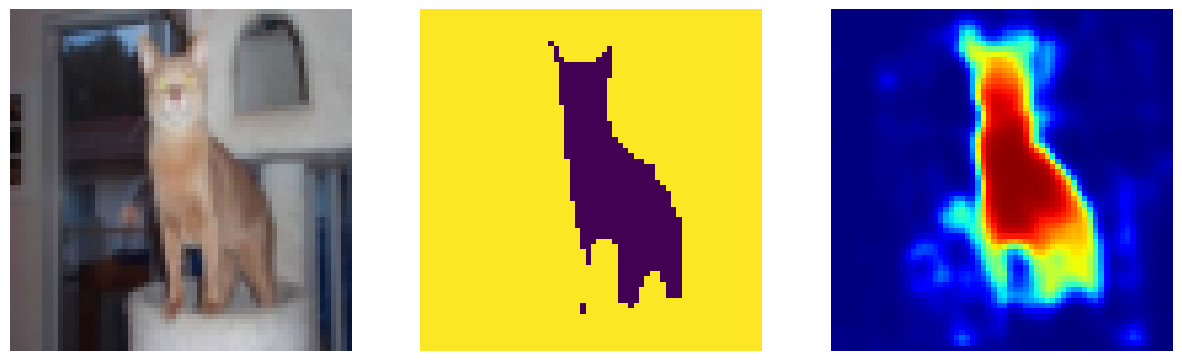

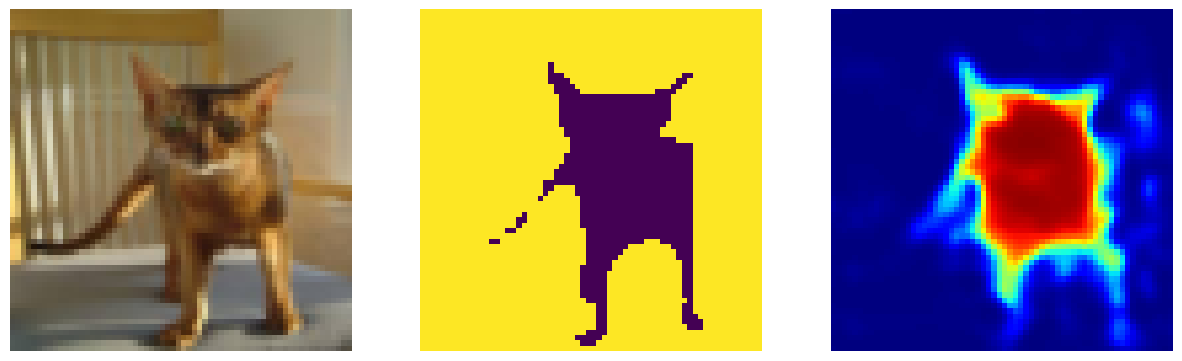

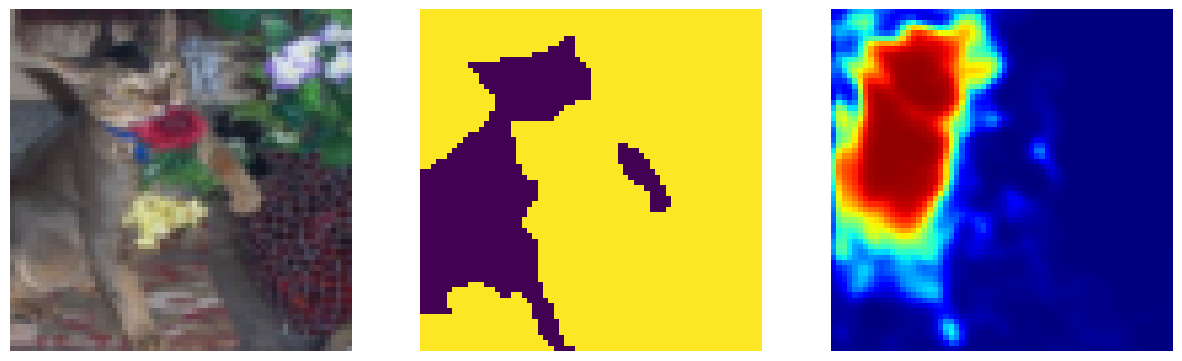

In [90]:
def display(display_list, titles=None, cmaps={}):
    """ Plotting images in list """
    from matplotlib import cm
    from matplotlib import pyplot as plt
    plt.figure(figsize=(15, 15))

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        if titles != None:
            plt.title(titles[i])
        plt.imshow(
            display_list[i],
            vmin=0,
            vmax=1,
            cmap=cmaps[i] if i in cmaps else None
        )
        plt.axis('off')
    plt.show()


cnt = 0
for image, (mask, label) in test_data:
    if cnt == 4:
        break
    cnt += 1
    # TODO: Get the output from your network
    out = torch.nn.functional.softmax(seg_model(image[None].to(device)), 1).cpu().detach().numpy()[0, label, :, :]

    #TODO: plot the output
    display([image.permute(1, 2, 0).numpy(), mask.numpy().squeeze(), out.squeeze()], cmaps={2: 'jet'})

## Extra challenge

Using the streigh forward fully-convolutional approach is simple, but you do lose much of the spatial information, makeing the network less precise. A better approach is to us a [U-Net](https://arxiv.org/pdf/1505.04597.pdf) type architecture. Here you make skip-connection, either by simple addition or by concatinating the outputs. This can be done by only changing the *call* method in the network. Then the output can be resized multiple times with tf.image.resize and the skip-connection can be done with [torch.cat](https://pytorch.org/docs/stable/generated/torch.cat.html) or simply +. It is not necessary to use max-pooling or up-convolution/Conv2DTransposed.

![u-net](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs41598-019-53797-9/MediaObjects/41598_2019_53797_Fig1_HTML.png)

In [87]:
import time

import cv2
import numpy as np
import torch
from torch.nn import Conv2d, Linear, Dropout
from torch.nn.functional import interpolate
from torch.nn.functional import relu
from torchvision import models


class USegNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(USegNet, self).__init__()
        self.num_classes = num_classes
        # TODO: Initialize the layers of your network
        # You can find different layers in torch.nn
        weights = models.ResNet18_Weights.DEFAULT
        self.n = models.resnet18(weights=weights)
        self.transforms = weights.transforms()
        self.n.eval()
        for param in self.n.parameters():
            param.requires_grad = False
        self.up4 = Conv2d(512, 256, 3, stride=1, padding='same')
        self.up3 = Conv2d(256, 128, 3, stride=1, padding='same')
        self.up2 = Conv2d(128, 64, 3, stride=1, padding='same')
        self.f1 = Conv2d(64, 64, 1, stride=1, padding='same')
        self.f2 = Conv2d(64, num_classes, 1, stride=1, padding='same')

    def forward(self, x, output_features=False):
        in_size = x.shape
        # TODO: Run the image through your network
        # Your input should be a [Batch_size x 3 x 32 x 32] sized tensor
        # Your output should be a [Batch_size x num_classes] sized matrix
        x = self.n.conv1(self.transforms(x))
        x = self.n.bn1(x)
        x = self.n.relu(x)
        x = self.n.maxpool(x)

        x1 = self.n.layer1(x)
        x2 = self.n.layer2(x1)
        x3 = self.n.layer3(x2)
        x4 = self.n.layer4(x3)
        up4 = relu(self.up4(interpolate(x4, x3.shape[-2:], mode='bilinear')) + x3)
        up3 = relu(self.up3(interpolate(up4, x2.shape[-2:], mode='bilinear')) + x2)
        up2 = relu(self.up2(interpolate(up3, x1.shape[-2:], mode='bilinear')) + x1)
        f1 = relu(self.f1(up2))
        f2 = self.f2(f1)
        # Output features of your second last layer
        if output_features: return x

        # Return the result of your network
        return interpolate(f2, in_size[2:4], mode='bilinear')

    @staticmethod
    def compute_loss(pred, label):
        return torch.mean((pred - label) ** 2)


model = USegNet(2)
model(torch.rand((1, 3, 128, 128)))

tensor([[[[ 0.7730,  0.7781,  0.7923,  ...,  0.4600,  0.5024,  0.5176],
          [ 0.7370,  0.7377,  0.7395,  ...,  0.4293,  0.4809,  0.4993],
          [ 0.6365,  0.6246,  0.5915,  ...,  0.3432,  0.4206,  0.4483],
          ...,
          [ 0.2041,  0.2233,  0.2770,  ...,  0.2221,  0.2046,  0.1983],
          [ 0.2686,  0.2754,  0.2945,  ...,  0.2700,  0.2149,  0.1952],
          [ 0.2917,  0.2941,  0.3008,  ...,  0.2870,  0.2186,  0.1941]],

         [[ 0.1730,  0.1824,  0.2088,  ...,  0.0766,  0.0975,  0.1050],
          [ 0.1364,  0.1461,  0.1730,  ...,  0.0378,  0.0767,  0.0907],
          [ 0.0341,  0.0443,  0.0728,  ..., -0.0707,  0.0187,  0.0506],
          ...,
          [-0.1633, -0.1419, -0.0821,  ..., -0.2097, -0.1541, -0.1343],
          [-0.0827, -0.0741, -0.0501,  ..., -0.1781, -0.1612, -0.1551],
          [-0.0539, -0.0499, -0.0387,  ..., -0.1668, -0.1637, -0.1626]]]],
       grad_fn=<UpsampleBilinear2DBackward1>)